In [80]:
import pandas as pd
from pycaret.regression import *

df = pd.read_csv('consumption_temp.csv')

start_time = '2022-08-07 21:00:00'
end_time = '2022-12-07 21:00:00'
location = 'oslo'

start_time = pd.to_datetime(start_time)
end_time = pd.to_datetime(end_time)

data = df[df['location'].str.lower() == location.lower()]
data['time'] = pd.to_datetime(data['time'])

# Filter the training data based on the start and end time
data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

# Create hour feature
data['hour'] = data['time'].dt.hour
# Create weekday feature
data['weekday'] = data['time'].dt.weekday

# Remove the last 5 days of consumption data
data['consumption'] = data['consumption'].shift(120)
data.dropna(subset=['consumption'], inplace=True)

In [81]:
regression_setup = setup(data=data, target='consumption', session_id=123,
                         numeric_features=['temperature', 'hour', 'weekday'], 
                         transform_target=True, data_split_shuffle=False)

,Description,Value
0,Session id,123
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(2809, 6)"
4,Transformed data shape,"(2809, 8)"
5,Transformed train set shape,"(1966, 8)"
6,Transformed test set shape,"(843, 8)"
7,Numeric features,3
8,Date features,1
9,Categorical features,1


In [82]:
# Compare models to select the best one in the next block (comment if already selected)
best_model = compare_models()


In [83]:
# Create the model with the desired model
model = create_model(best_model)

tuned_model = tune_model(model)

final_model = finalize_model(tuned_model)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:13:54
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0136,0.0003,0.0181,0.9010,0.0095,0.0151
1,0.0154,0.0005,0.0231,0.8655,0.0120,0.0167
2,0.0248,0.0010,0.0322,0.7079,0.0167,0.0270
3,0.0263,0.0011,0.0330,0.6478,0.0165,0.0265
4,0.0181,0.0005,0.0217,0.8277,0.0110,0.0188
5,0.0208,0.0006,0.0247,0.5748,0.0127,0.0218
6,0.0220,0.0007,0.0259,-0.0659,0.0139,0.0260
7,0.0084,0.0001,0.0101,0.4574,0.0057,0.0107
8,0.0083,0.0001,0.0107,0.4875,0.0059,0.0103


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0669,0.0063,0.0793,-0.9074,0.0417,0.0773
1,0.0610,0.0054,0.0735,-0.3607,0.0387,0.0703
2,0.0855,0.0102,0.1010,-1.8799,0.0516,0.0943
3,0.0629,0.0060,0.0773,-0.9342,0.0388,0.0660
4,0.0506,0.0040,0.0631,-0.4582,0.0319,0.0533
5,0.0290,0.0011,0.0330,0.2406,0.0170,0.0307
6,0.0196,0.0005,0.0230,0.1561,0.0124,0.0229
7,0.0347,0.0013,0.0365,-6.0728,0.0207,0.0444
8,0.0465,0.0023,0.0484,-9.5226,0.0270,0.0571


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


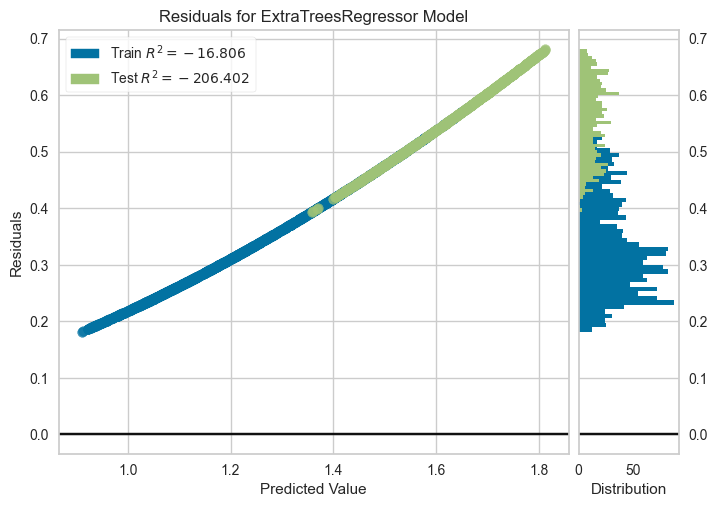

In [84]:
plot_model(final_model)

In [85]:
from datetime import timedelta

number_predict_hours = 24

# The last known time from the original data
last_time = data['time'].iloc[-1]

# Generating future timestamps for the next 24 hours (the hours we want to predict)
future_timestamps = [last_time + timedelta(hours=i) for i in range(1, number_predict_hours + 1)]

future_data = df[df['location'].str.lower() == location.lower()]
future_data['time'] = pd.to_datetime(future_data['time'])

# Limit future data to the next 24 hours after the last known time
future_data = future_data[(future_data['time'] > last_time) & (future_data['time'] <= future_timestamps[-1])]
future_hours = future_data['time'].dt.hour
future_weekdays = future_data['time'].dt.weekday
future_temperatures = future_data['temperature'].values

print(len(future_data))

# Creating the future_data DataFrame, which will be used for the prediction
future_data = pd.DataFrame({
    'time': future_timestamps,
    'temperature': future_temperatures,
    'location': location,
    'hour': future_hours,
    'weekday': future_weekdays
})

# Predict the consumption for the next 24 hours using the trained model
future_data['time'] = pd.to_datetime(future_data['time'])
predictions = predict_model(final_model, data=future_data)

24


In [86]:
predictions

,time,temperature,location,hour,weekday,prediction_label
32792,2022-12-07 22:00:00,-6.5,oslo,22,2,10.913512
32798,2022-12-07 23:00:00,-6.9,oslo,23,2,10.407821
32804,2022-12-08 00:00:00,-6.8,oslo,0,3,9.864564
32810,2022-12-08 01:00:00,-6.5,oslo,1,3,9.773155
32816,2022-12-08 02:00:00,-6.3,oslo,2,3,9.682063
32822,2022-12-08 03:00:00,-6.3,oslo,3,3,9.645942
32828,2022-12-08 04:00:00,-6.1,oslo,4,3,9.640828
32834,2022-12-08 05:00:00,-7.1,oslo,5,3,10.235423
32840,2022-12-08 06:00:00,-7.4,oslo,6,3,10.691161
32846,2022-12-08 07:00:00,-7.3,oslo,7,3,10.652492


In [92]:
import pandas as pd
from pycaret.regression import *

solution = df[df['location'].str.lower() == location.lower()]
solution['time'] = pd.to_datetime(solution['time'])

# Filter the training data based on the start and end time
solution = solution[(solution['time'] > last_time) & (solution['time'] <= future_timestamps[-1])]

# Create hour feature
solution['hour'] = solution['time'].dt.hour
# Create weekday feature
solution['weekday'] = solution['time'].dt.weekday
# Merge the DataFrames
merged_data = predictions.copy()
merged_data['consumption'] = solution['consumption']
merged_data.head()

,time,temperature,location,hour,weekday,prediction_label,consumption
32792,2022-12-07 22:00:00,-6.5,oslo,22,2,10.913512,14.222321
32798,2022-12-07 23:00:00,-6.9,oslo,23,2,10.407821,13.597456
32804,2022-12-08 00:00:00,-6.8,oslo,0,3,9.864564,13.189309
32810,2022-12-08 01:00:00,-6.5,oslo,1,3,9.773155,13.020150
32816,2022-12-08 02:00:00,-6.3,oslo,2,3,9.682063,12.849883


<Axes: title={'center': 'Predictions for the next 24 hours'}, xlabel='time', ylabel='MV'>

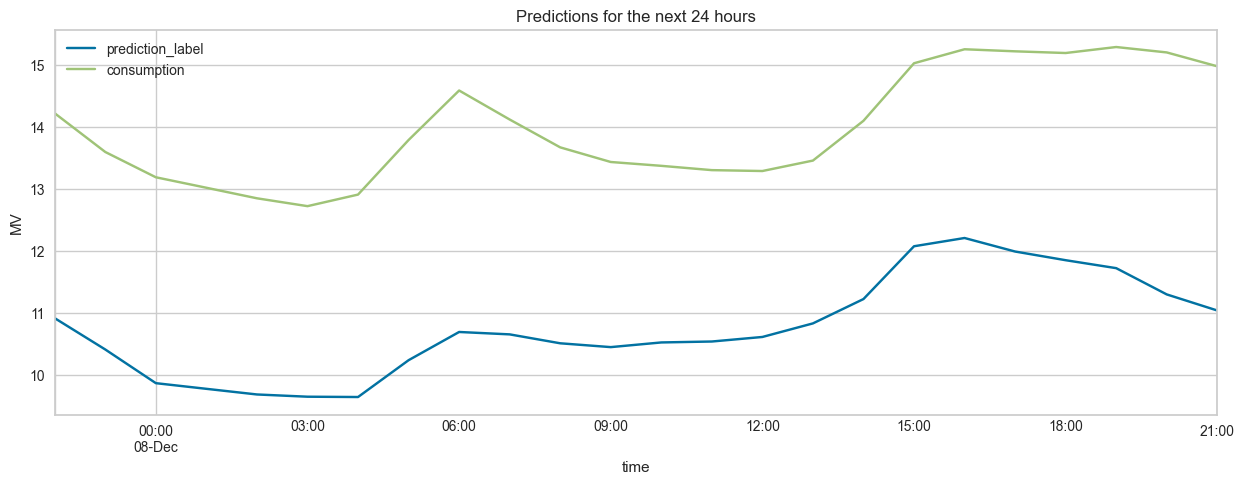

In [93]:
merged_data.plot(x='time', y=['prediction_label', 'consumption'], ylabel="MV", figsize=(15, 5), title=f'Predictions for the next {number_predict_hours} hours')